# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Risk_analytics

# Data Preprocessing

In [2]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("returns.csv")[1:]
rets.head()

,Date,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
1,2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2,2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
3,2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
4,2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
5,2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [3]:
# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']
rets.head()

,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,USA_EWU,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,0.010462,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,-0.002157,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,-0.008647,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,-0.003925,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,0.001751,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [4]:
# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [5]:
sum(rets["USA_RUB=X"] > 100)

0

In [6]:
rets.index

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13',
               '2011-01-14', '2011-01-17',
               ...
               '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
               '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
               '2021-07-02', '2021-07-05'],
              dtype='datetime64[ns]', name='Date', length=2740, freq=None)

In [7]:
# read the risk free rate
riskfree = pd.read_csv("3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])
riskfree.head()

,Date,RFR
0,2010-01-01,0.061
1,2010-01-04,0.060
2,2010-01-05,0.066
3,2010-01-06,0.054
4,2010-01-07,0.049


In [8]:
riskfree

,Date,RFR
0,2010-01-01,0.061
1,2010-01-04,0.060
2,2010-01-05,0.066
3,2010-01-06,0.054
4,2010-01-07,0.049
...,...,...
3001,2021-07-05,0.044
3002,2021-07-06,0.047
3003,2021-07-07,0.048
3004,2021-07-08,0.048


In [9]:
# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')
riskfree.head()

,RFR
Date,
2011-01-04,0.140
2011-01-05,0.140
2011-01-06,0.145
2011-01-07,0.140
2011-01-10,0.140


In [10]:
# daily risk free
riskfree = (1 + riskfree).pow(1/252) - 1
riskfree.head()

,RFR
Date,
2011-01-04,0.000520
2011-01-05,0.000520
2011-01-06,0.000537
2011-01-07,0.000520
2011-01-10,0.000520


In [11]:
len(riskfree.index) == len(rets.index)

True

In [12]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31',
               '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31',
               '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31',
               '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31',
               '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31',
               '2021-01-31'],
              dtype='datetime64[ns]', freq='6M')

In [13]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [14]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])

2011-01-31 00:00:00 2011-07-29 00:00:00


In [15]:
# Sanity check
print(semiannual[1].index[0],semiannual[1].index[-1])

2011-08-01 00:00:00 2012-01-31 00:00:00


In [16]:
# Sanity check
print(semiannual[19].index[0],semiannual[19].index[-1])

2020-07-31 00:00:00 2021-01-29 00:00:00


# Lowest correlation Search

In [17]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)
corrs

USA_EWJ      0.435156
USA_EWT      0.511699
USA_MCHI     0.528725
USA_EWY      0.541586
USA_EWZ      0.432182
               ...   
USA_ZAR=X    0.118197
USA_RUB=X    0.084428
USA_EUR=X    0.151444
USA_JPY=X    0.082320
USA_MXN=X    0.462142
Length: 128, dtype: float64

In [18]:
# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:30]

CAN_XFR.TO    0.075507
CAN_CMR.TO    0.081464
USA_JPY=X     0.082320
USA_RUB=X     0.084428
USA_BRL=X     0.085703
CAN_HXQ.TO    0.097759
CAN_HHF.TO    0.113232
CAN_CBO.TO    0.113303
USA_ZAR=X     0.118197
USA_CNY=X     0.120320
CAN_HUZ.TO    0.144101
USA_EUR=X     0.151444
CAN_XSC.TO    0.154957
CAN_SVR.TO    0.162192
CAN_HXF.TO    0.165272
CAN_XGD.TO    0.181217
CAN_HUN.TO    0.185430
CAN_XIG.TO    0.186638
CAN_CVD.TO    0.190808
USA_KSA       0.198407
CAN_CBH.TO    0.199100
CAN_HUG.TO    0.208522
CAN_HTB.TO    0.237717
CAN_XUU.TO    0.248717
CAN_CGL.TO    0.253634
CAN_CLF.TO    0.280254
CAN_CGR.TO    0.283629
CAN_CLG.TO    0.284980
CAN_HXE.TO    0.285884
USA_QAT       0.286492
dtype: float64

In [19]:
# First 15 CAN values
[x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

['CAN_XFR.TO',
 'CAN_CMR.TO',
 'CAN_HXQ.TO',
 'CAN_HHF.TO',
 'CAN_CBO.TO',
 'CAN_HUZ.TO',
 'CAN_XSC.TO',
 'CAN_SVR.TO',
 'CAN_HXF.TO',
 'CAN_XGD.TO',
 'CAN_HUN.TO',
 'CAN_XIG.TO',
 'CAN_CVD.TO',
 'CAN_CBH.TO',
 'CAN_HUG.TO']

In [20]:
# Loop through each semiannual period, save the 10, 15 or 30 Canadian and USA assets with the
# lowest average correlation
top10 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top10[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:10]
    top10[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:10]

top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top15[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

top30 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top30[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:30]
    top30[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:30]

In [21]:
# We only need the index
top30[1]

['USA_JPY=X',
 'USA_ZAR=X',
 'USA_RUB=X',
 'USA_BRL=X',
 'USA_EUR=X',
 'USA_CNY=X',
 'USA_EPU',
 'USA_TUR',
 'USA_EPHE',
 'USA_ECH',
 'USA_EWJ',
 'USA_THD',
 'USA_EIRL',
 'USA_EIDO',
 'USA_MCHI',
 'USA_EIS',
 'USA_EWZ',
 'USA_EWH',
 'USA_ERUS',
 'USA_MXN=X',
 'USA_ENZL',
 'USA_EWL',
 'USA_EWT',
 'USA_EWW',
 'USA_EWY',
 'USA_EWM',
 'USA_EWP',
 'USA_EWS',
 'USA_EPOL',
 'USA_EZA',
 'CAN_CMR.TO',
 'CAN_HUN.TO',
 'CAN_CVD.TO',
 'CAN_CGL.TO',
 'CAN_HUG.TO',
 'CAN_XIG.TO',
 'CAN_CGR.TO',
 'CAN_DLR.TO',
 'CAN_XGD.TO',
 'CAN_HUC.TO',
 'CAN_CBO.TO',
 'CAN_CHB.TO',
 'CAN_HUZ.TO',
 'CAN_SVR.TO',
 'CAN_CWW.TO',
 'CAN_CLF.TO',
 'CAN_XPF.TO',
 'CAN_HXS.TO',
 'CAN_COW.TO',
 'CAN_XHY.TO',
 'CAN_HXT.TO',
 'CAN_XUU.TO',
 'CAN_XDG.TO',
 'CAN_XBM.TO',
 'CAN_XDGH.TO',
 'CAN_XGGB.TO',
 'CAN_CLG.TO',
 'CAN_CBH.TO',
 'CAN_XSE.TO',
 'CAN_XFR.TO']

# Equally-weighted portfolio

In [22]:
# Let's create a one-period example before looping through them all, start
# with 100k capital
capital = 100000

In [23]:
# Use previous period's lowest corrs to construct portfolio
# for current period
returns = semiannual[1][top30[1]]
returns

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_HXT.TO,CAN_XUU.TO,CAN_XDG.TO,CAN_XBM.TO,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO,CAN_XFR.TO
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,-0.017975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,0.006744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,-0.031579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,-0.016798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-25,0.008922,0.002244,-0.002271,0.003653,-0.001042,0.001267,0.022340,0.020039,-0.001661,-0.003078,...,0.011605,NaN,NaN,0.026786,NaN,NaN,NaN,NaN,NaN,-0.001115
2012-01-26,0.001068,-0.009787,-0.010080,0.000910,-0.005086,-0.001345,0.015814,0.019918,-0.011231,0.004245,...,-0.008604,NaN,NaN,-0.003953,NaN,NaN,NaN,NaN,NaN,0.000000
2012-01-27,-0.003986,-0.006987,-0.004352,0.052557,0.001180,0.003247,0.001981,0.027822,0.020194,0.005573,...,0.002893,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000


In [24]:
# Save the sum of the dollar returns, add to capital
capital += returns.cumsum().iloc[-1,:].sum()
capital

99998.90786344971

In [25]:
returns.columns

Index(['USA_JPY=X', 'USA_ZAR=X', 'USA_RUB=X', 'USA_BRL=X', 'USA_EUR=X',
       'USA_CNY=X', 'USA_EPU', 'USA_TUR', 'USA_EPHE', 'USA_ECH', 'USA_EWJ',
       'USA_THD', 'USA_EIRL', 'USA_EIDO', 'USA_MCHI', 'USA_EIS', 'USA_EWZ',
       'USA_EWH', 'USA_ERUS', 'USA_MXN=X', 'USA_ENZL', 'USA_EWL', 'USA_EWT',
       'USA_EWW', 'USA_EWY', 'USA_EWM', 'USA_EWP', 'USA_EWS', 'USA_EPOL',
       'USA_EZA', 'CAN_CMR.TO', 'CAN_HUN.TO', 'CAN_CVD.TO', 'CAN_CGL.TO',
       'CAN_HUG.TO', 'CAN_XIG.TO', 'CAN_CGR.TO', 'CAN_DLR.TO', 'CAN_XGD.TO',
       'CAN_HUC.TO', 'CAN_CBO.TO', 'CAN_CHB.TO', 'CAN_HUZ.TO', 'CAN_SVR.TO',
       'CAN_CWW.TO', 'CAN_CLF.TO', 'CAN_XPF.TO', 'CAN_HXS.TO', 'CAN_COW.TO',
       'CAN_XHY.TO', 'CAN_HXT.TO', 'CAN_XUU.TO', 'CAN_XDG.TO', 'CAN_XBM.TO',
       'CAN_XDGH.TO', 'CAN_XGGB.TO', 'CAN_CLG.TO', 'CAN_CBH.TO', 'CAN_XSE.TO',
       'CAN_XFR.TO'],
      dtype='object')

<AxesSubplot:xlabel='Date'>

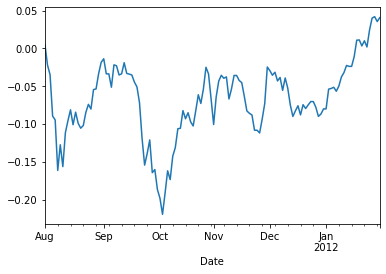

In [26]:
# Sanity check to make sure calculation is correct
returns['USA_EPU'].cumsum().plot()

In [27]:
# Reallocate capital and rebalance
position_size = capital / 60
position_size

1666.6484643908286

In [28]:
# Use new allocations to calculate next period
returns2 = semiannual[2][top30[2]] * position_size
returns2

,USA_CNY=X,USA_JPY=X,USA_RUB=X,USA_BRL=X,USA_ZAR=X,USA_EUR=X,USA_KXI,USA_ACWV,USA_MXN=X,USA_EPHE,...,CAN_XHY.TO,CAN_HXT.TO,CAN_XBM.TO,CAN_XUU.TO,CAN_XDG.TO,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,-2.740851,-8.079983,13.083646,7.959253,18.251904,8.805434,-2.534827,0.790818,11.019015,25.986512,...,2.763928,-1.605634,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,-1.319888,-1.964358,-16.573130,-1.431583,-7.749675,7.883241,16.501470,15.413633,-21.535632,42.184878,...,2.759352,6.428731,10.700793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-02,-0.475536,-1.770008,4.270869,-12.513236,-27.763928,-11.769193,-1.885349,1.566399,-12.163995,28.328303,...,1.377395,4.803022,14.619723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-03,-0.687082,-0.196877,1.847824,-13.089114,-5.307521,4.170462,14.470711,7.824641,-17.285152,8.621739,...,2.752516,4.789220,18.445121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-06,0.105748,8.116652,0.817889,-2.716149,-21.123333,1.313701,-3.742474,-12.460923,0.658609,-3.958785,...,0.000000,-3.183665,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,0.391471,-4.341616,15.288337,7.447702,12.242592,8.688880,0.000000,7.577397,-13.312277,4.907320,...,-4.012797,3.432850,-3.638970,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2012-07-26,0.260919,-0.085352,-13.387345,-10.429284,-22.016880,-10.855026,40.103360,20.743531,-24.155036,23.241336,...,16.089929,22.267657,12.764266,NaN,NaN,NaN,NaN,-4.365811,-2.276842,NaN
2012-07-27,-1.173953,4.715943,-18.977759,-10.330974,-30.720625,-19.019662,24.763609,18.253414,-21.301922,20.508884,...,7.968040,16.903128,54.288224,NaN,NaN,NaN,NaN,-6.565916,-7.979849,NaN


In [29]:
# Concatenate to get continuous stream
pd.concat([returns, returns2])

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO,CAN_XFR.TO,USA_KXI,USA_ACWV,USA_IXJ,USA_EWI
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,-4.341616,12.242592,15.288337,7.447702,8.688880,0.391471,-5.475846,23.005254,4.907320,-3.213126,...,NaN,NaN,0.000000,0.000000,NaN,0.9208,0.000000,7.577397,9.215276,37.904479
2012-07-26,-0.085352,-22.016880,-13.387345,-10.429284,-10.855026,0.260919,17.980025,66.860442,23.241336,-5.472865,...,NaN,NaN,-4.365811,-2.276842,NaN,0.0000,40.103360,20.743531,24.220736,108.938613
2012-07-27,4.715943,-30.720625,-18.977759,-10.330974,-19.019662,-1.173953,24.211614,38.958590,20.508884,19.702627,...,NaN,NaN,-6.565916,-7.979849,NaN,0.0000,24.763609,18.253414,30.326163,80.117194


# Portfolio weight optimization -- MVO, Risk Parity and Sharpe Ratio Maximization results

In [30]:
import warnings
warnings.filterwarnings('ignore')

import portfolio_optimizer

from importlib import reload
reload(portfolio_optimizer)

from portfolio_optimizer import portfolio_optimizer

10 cutoff ETFs

In [31]:
opt10 = portfolio_optimizer(semiannual)

# MVO:
pct_full_portfolio_mvo, dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt10.portfolio_simulator(100000, riskfree, top10, 10, 'MVO')
# Risk parity
pct_full_portfolio_rp, dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt10.portfolio_simulator(100000, riskfree, top10, 10, 'Risk parity')
# Sharpe Ratio Maximization
pct_full_portfolio_sr, dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt10.portfolio_simulator(100000, riskfree, top10, 10, 'Sharpe ratio maximization')

Max drawdown: -244.5245918255228%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-776.066173,-1273.028373,-1075.151003,-1519.526670
3,-595.307478,-765.741387,-713.059955,-894.003257
4,-529.060108,-794.243544,-681.730650,-858.875432
5,-476.028431,-615.003661,-555.748552,-634.008005
6,-409.127545,-469.701460,-467.016511,-551.410574
7,-1133.427348,-1693.629318,-1512.495713,-1739.465065
8,-634.435279,-984.389029,-840.064704,-1147.984884
9,-954.222927,-1603.816582,-1914.565895,-3938.133995
10,-552.219119,-891.775194,-783.983222,-1130.815113


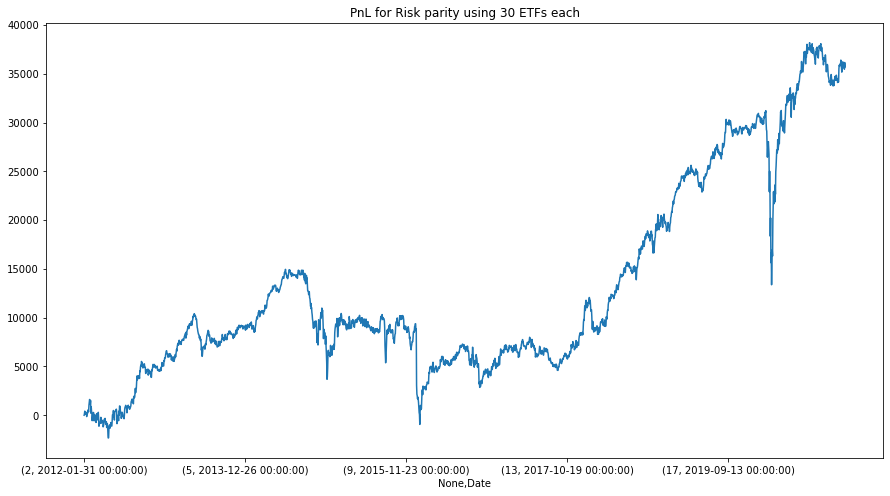

In [32]:
pd.concat(PnL_mvo).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown: -244.523782610038%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-776.063940,-1273.024449,-1075.147984,-1519.522004
3,-595.307192,-765.740852,-713.059518,-894.002786
4,-529.059982,-794.243298,-681.730539,-858.875317
5,-476.028267,-615.003355,-555.748194,-634.007562
6,-409.127561,-469.701421,-467.016496,-551.410528
7,-1133.426185,-1693.628671,-1512.494788,-1739.464112
8,-634.435117,-984.389043,-840.064588,-1147.984628
9,-954.222913,-1603.816802,-1914.565446,-3938.132556
10,-552.219850,-891.774060,-783.982838,-1130.814535


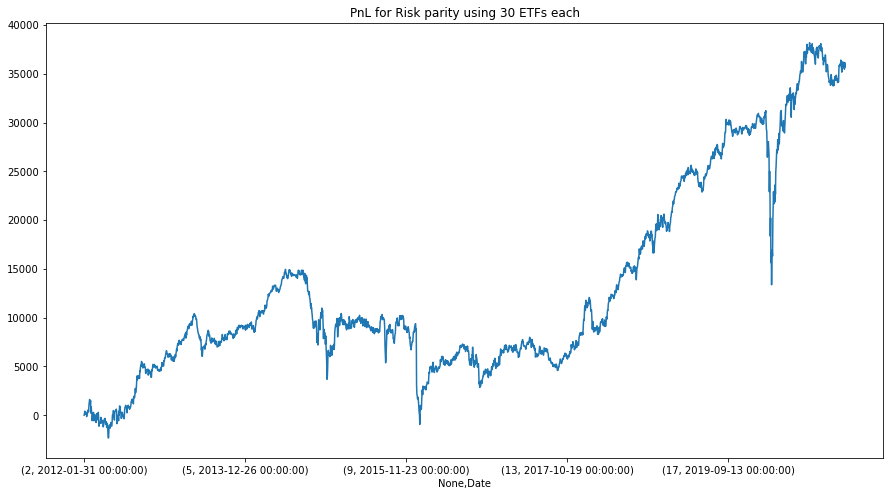

In [33]:
pd.concat(PnL_rp).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_rp}')
overallrisk_rp

Max drawdown: -159.70026702474522%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-443.989387,-725.173060,-618.543247,-850.531051
3,-609.429665,-798.442045,-732.888793,-878.664238
4,-735.076190,-1095.975302,-939.601987,-1184.695056
5,-805.504013,-1550.681723,-1222.571098,-1701.972101
6,-692.676154,-1029.239863,-902.680023,-1137.886326
7,-1273.928569,-2249.405438,-1813.589699,-2425.227541
8,-684.856055,-1100.901080,-931.191457,-1228.021122
9,-1179.871252,-2543.183975,-1752.413296,-2755.947639
10,-1407.606925,-1856.678354,-1745.915446,-2193.374560


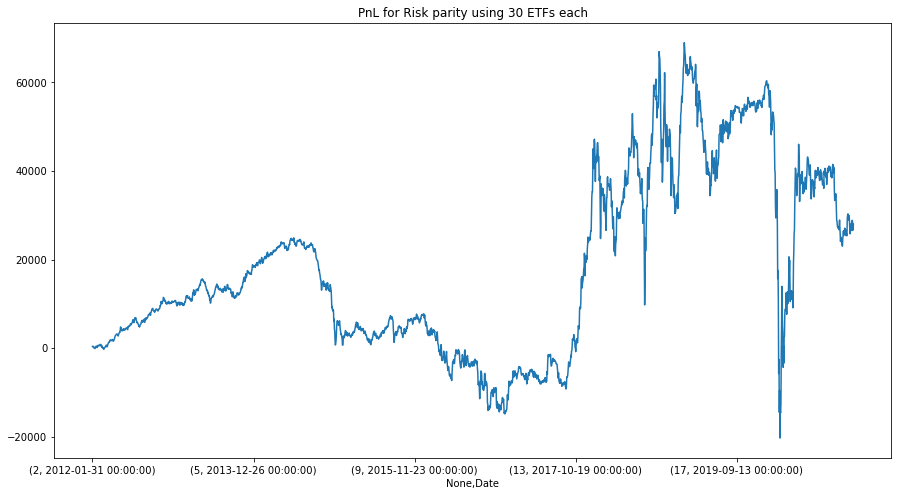

In [34]:
pd.concat(PnL_sr).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_sr}')
overallrisk_sr

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

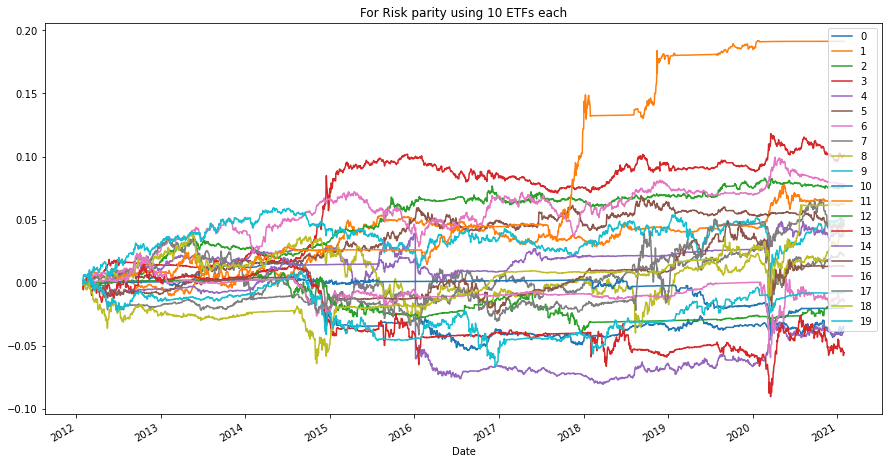

In [35]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

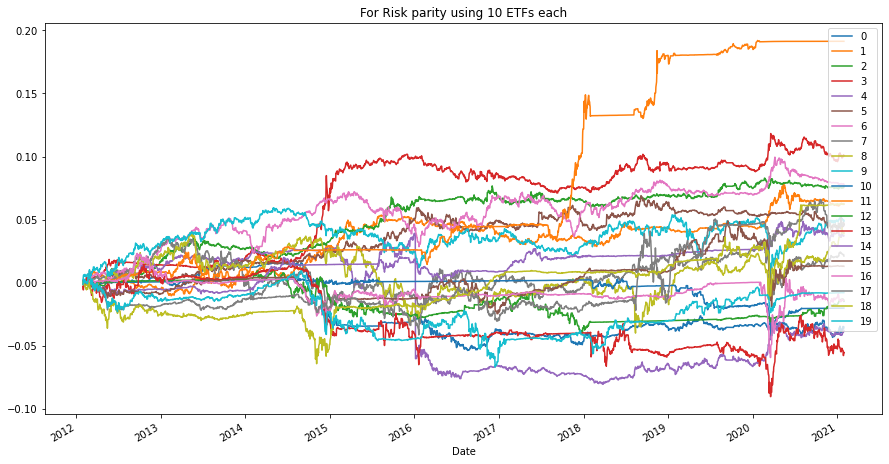

In [36]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Sharpe Ratio Maximization using 10 ETFs each')

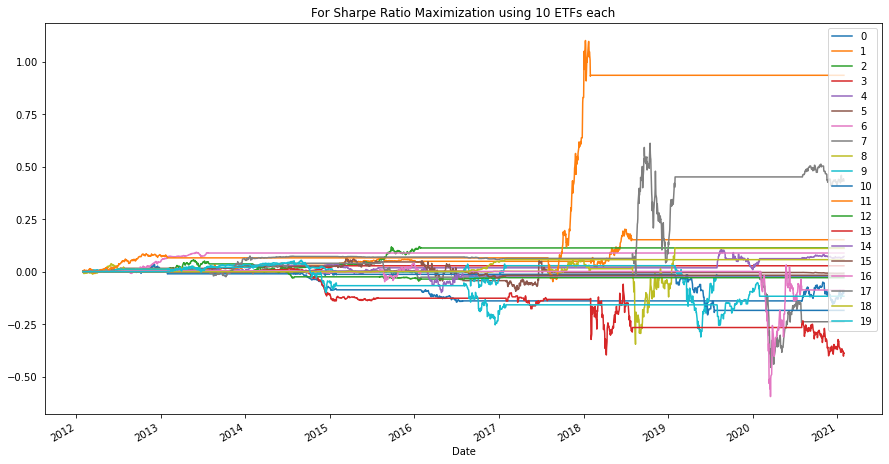

In [37]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.title('For Sharpe Ratio Maximization using 10 ETFs each')

15 cutoff ETFs

In [38]:
opt15 = portfolio_optimizer(semiannual)

# MVO:
pct_full_portfolio_mvo, dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt15.portfolio_simulator(100000, riskfree, top15, 15, 'MVO')
# Risk parity
pct_full_portfolio_rp, dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt15.portfolio_simulator(100000, riskfree, top15, 15, 'Risk parity')
# Sharpe Ratio Maximization
pct_full_portfolio_sr, dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt15.portfolio_simulator(100000, riskfree, top15, 15, 'Sharpe ratio maximization')

Max drawdown: -210.9137038558893%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-842.729674,-1302.625301,-1100.073110,-1407.256641
3,-537.230826,-784.348489,-711.801966,-892.613687
4,-691.906815,-1531.032930,-1070.767723,-1626.970160
5,-678.590340,-1021.617895,-876.770714,-1121.367985
6,-432.639227,-517.747806,-516.352943,-674.265632
7,-986.342092,-1470.363000,-1299.695633,-1604.288274
8,-810.173099,-1170.565306,-1068.763376,-1240.156764
9,-1010.310026,-2212.994457,-1690.232745,-3217.353519
10,-797.721220,-1237.205964,-1139.505988,-1753.382381


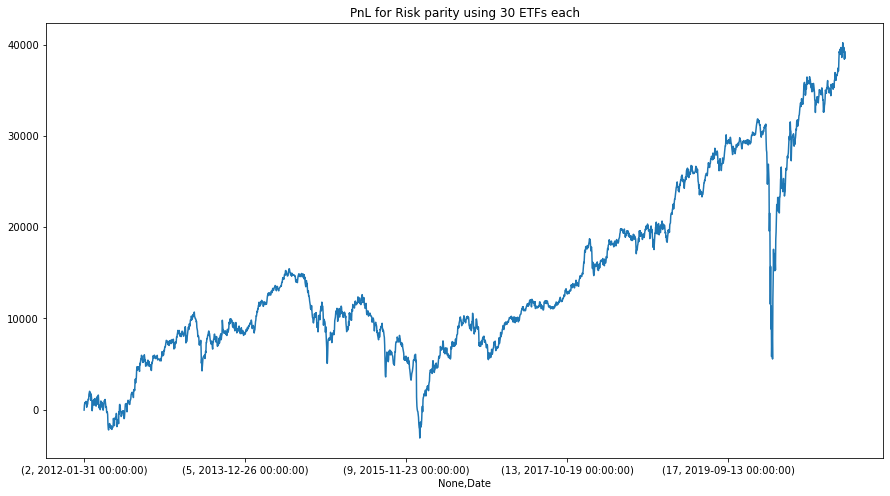

In [39]:
pd.concat(PnL_mvo).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown: -210.9127835568525%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-842.725782,-1302.619011,-1100.068128,-1407.249686
3,-537.229661,-784.347481,-711.800823,-892.612356
4,-691.906419,-1531.032457,-1070.767283,-1626.969516
5,-678.589351,-1021.616397,-876.769250,-1121.366381
6,-432.638992,-517.747495,-516.352744,-674.265281
7,-986.340924,-1470.361530,-1299.694601,-1604.286811
8,-810.171910,-1170.562482,-1068.761384,-1240.154278
9,-1010.309928,-2212.994096,-1690.232478,-3217.353170
10,-797.719667,-1237.204152,-1139.504222,-1753.380376


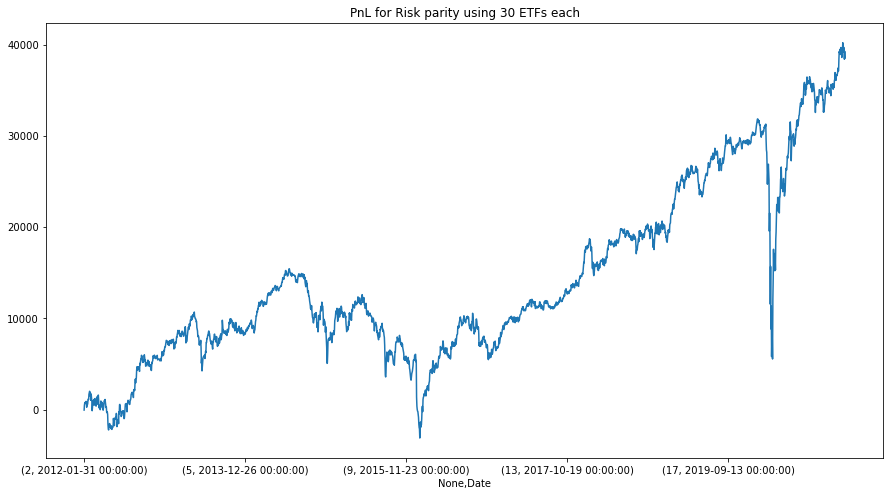

In [40]:
pd.concat(PnL_rp).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_rp}')
overallrisk_rp

Max drawdown: -271.40465571193795%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-341.175584,-464.111692,-411.745875,-510.450266
3,-461.585741,-566.467281,-554.402324,-692.857497
4,-1153.261616,-1832.266829,-1507.480598,-2114.268630
5,-756.350932,-1422.692275,-1108.762335,-1561.673446
6,-498.850141,-695.589760,-605.960640,-765.015281
7,-741.331783,-1374.845413,-1060.074947,-1434.933815
8,-538.635864,-835.052855,-696.595967,-872.630276
9,-1264.709945,-2585.767870,-1877.849289,-2950.389334
10,-1247.399243,-1688.373406,-1513.728941,-1748.505422


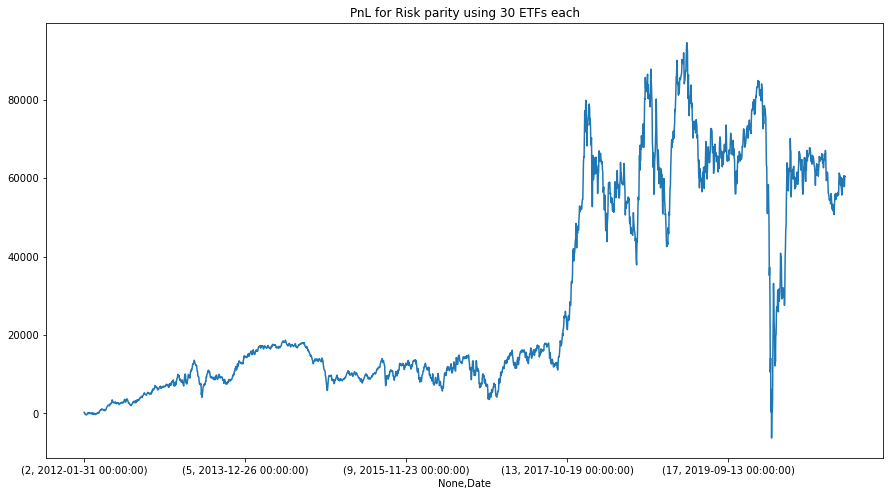

In [41]:
pd.concat(PnL_sr).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_sr}')
overallrisk_sr

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

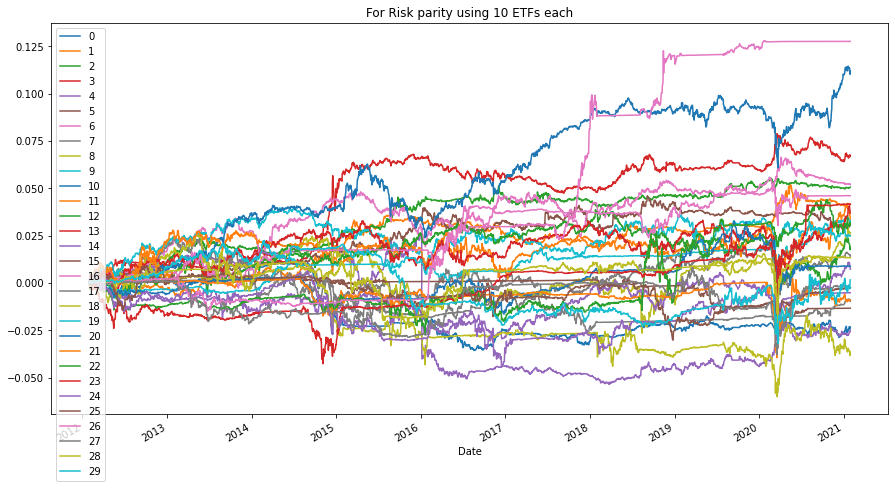

In [42]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

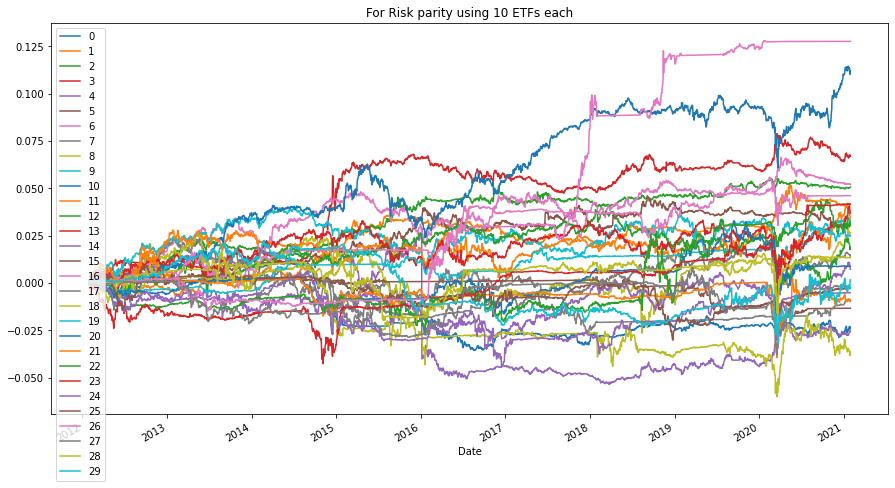

In [43]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Sharpe Ratio Maximization using 10 ETFs each')

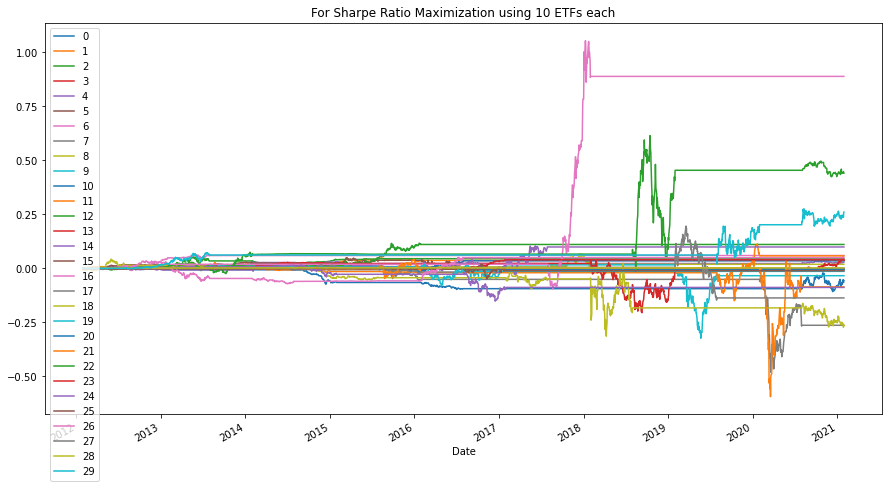

In [44]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.title('For Sharpe Ratio Maximization using 10 ETFs each')

30 cutoff ETFs

In [45]:
opt30 = portfolio_optimizer(semiannual)

# MVO:
pct_full_portfolio_mvo, dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt30.portfolio_simulator(100000, riskfree, top30, 30, 'MVO')
# Risk parity
pct_full_portfolio_rp, dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt30.portfolio_simulator(100000, riskfree, top30, 30, 'Risk parity')
# Sharpe Ratio Maximization
pct_full_portfolio_sr, dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt30.portfolio_simulator(100000, riskfree, top30, 30, 'Sharpe ratio maximization')

Max drawdown: -252.3673065436763%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-973.113213,-1520.422316,-1253.789605,-1531.234294
3,-547.304281,-954.883468,-771.398731,-991.357899
4,-907.399328,-1965.103351,-1509.834597,-2410.379698
5,-1019.254640,-1533.411588,-1293.750174,-1661.548001
6,-692.275043,-1124.439455,-960.501065,-1161.387872
7,-943.390764,-1242.240544,-1148.583828,-1394.291206
8,-839.901399,-1231.462207,-1074.284950,-1369.668060
9,-1174.692558,-2543.320829,-1814.041325,-2756.991255
10,-984.271118,-1703.628900,-1541.365513,-2398.203441


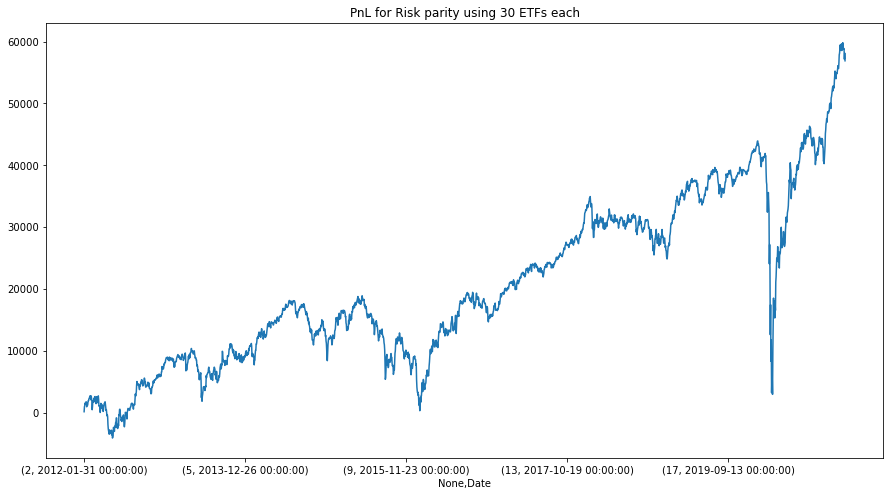

In [46]:
pd.concat(PnL_mvo).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown: -252.3648646224129%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-973.100746,-1520.407958,-1253.777403,-1531.219186
3,-547.302092,-954.880909,-771.396632,-991.355508
4,-907.398589,-1965.101535,-1509.833238,-2410.377266
5,-1019.251893,-1533.407880,-1293.746181,-1661.543330
6,-692.273004,-1124.438031,-960.498825,-1161.385871
7,-943.390423,-1242.239803,-1148.582730,-1394.289591
8,-839.899854,-1231.459962,-1074.283096,-1369.665722
9,-1174.692034,-2543.319074,-1814.040428,-2756.991922
10,-984.266230,-1703.622451,-1541.359621,-2398.195778


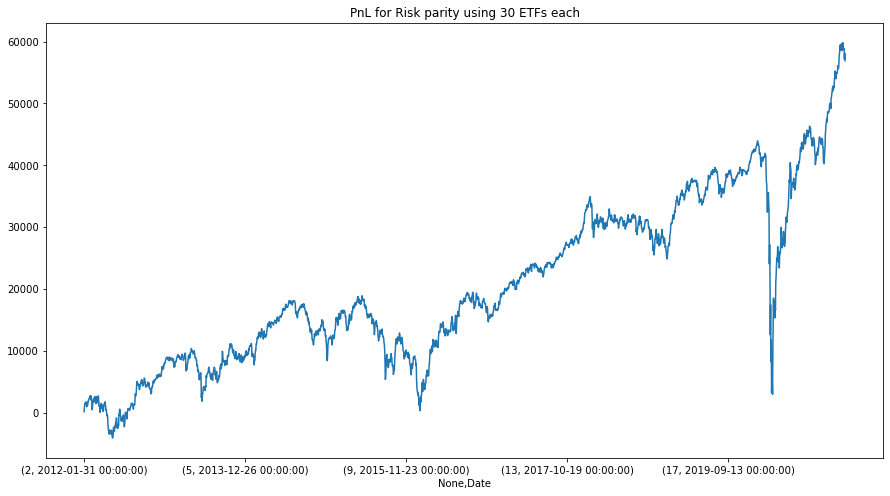

In [47]:
pd.concat(PnL_rp).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_rp}')
overallrisk_rp

Max drawdown: -279.069635707501%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-325.004079,-450.633086,-392.268322,-470.674680
3,-391.470286,-520.044845,-478.122691,-586.646820
4,-1236.868217,-1775.226764,-1582.255647,-2167.077632
5,-682.454326,-1106.830867,-954.369437,-1302.844815
6,-490.870719,-644.036092,-585.367682,-701.412486
7,-553.221846,-1020.161534,-783.615143,-1133.226812
8,-521.401627,-785.123269,-663.813062,-806.768988
9,-967.126080,-1266.469406,-1218.447120,-1638.661991
10,-1043.498516,-1392.533720,-1231.937005,-1457.072199


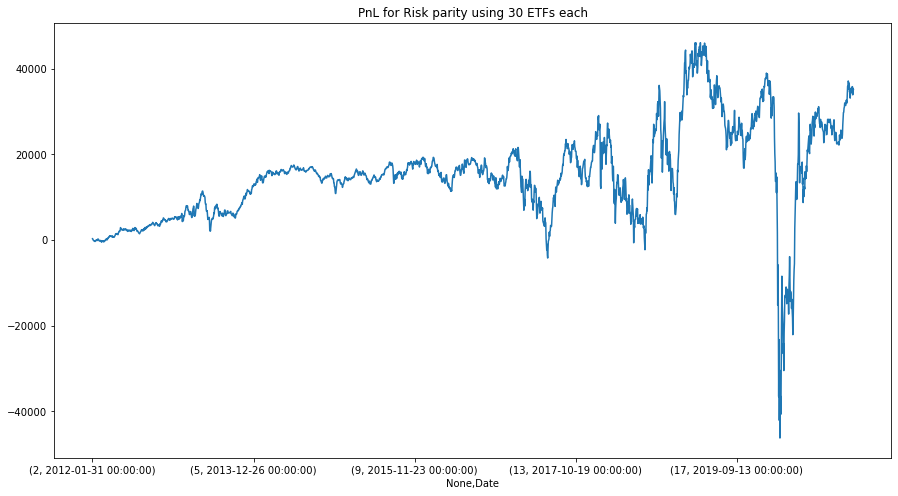

In [48]:
pd.concat(PnL_sr).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
print(f'Max drawdown: {max_drawdown_sr}')
overallrisk_sr

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

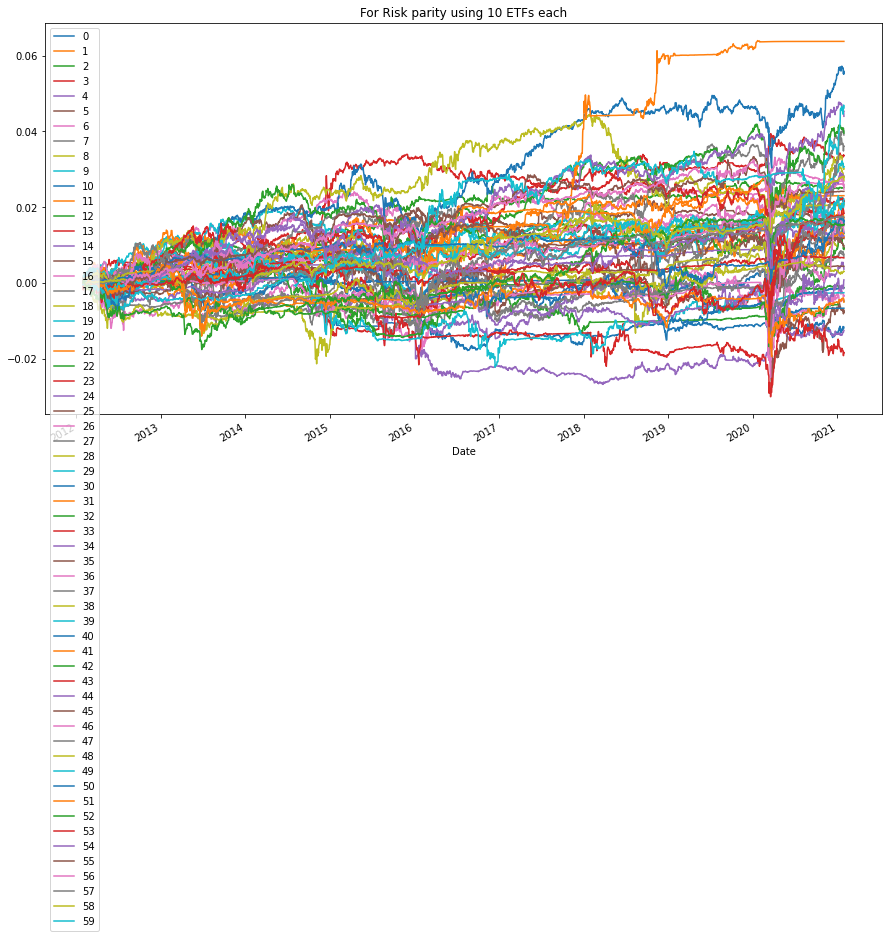

In [49]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

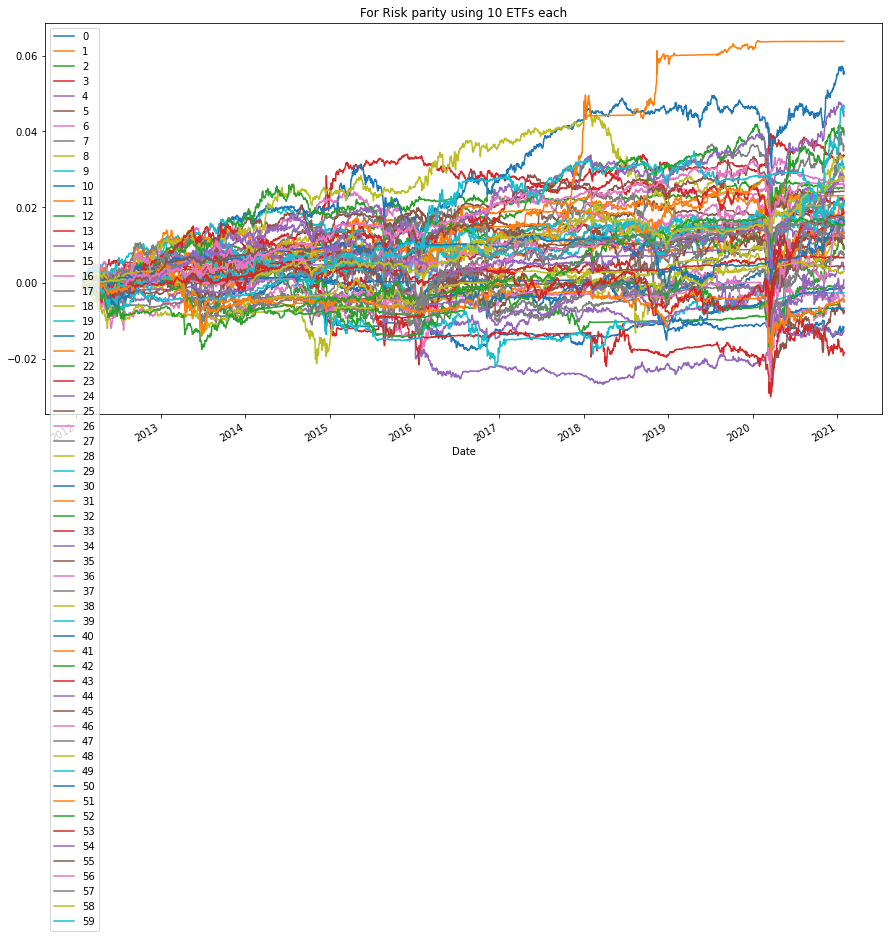

In [50]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Sharpe Ratio Maximization using 10 ETFs each')

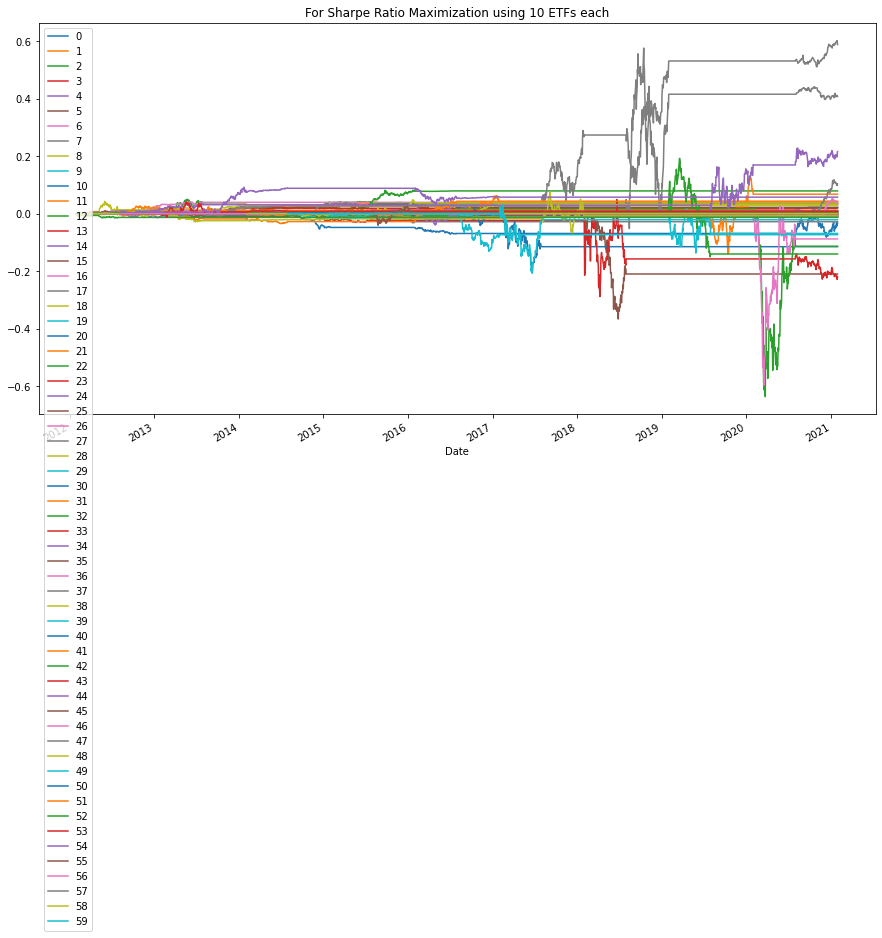

In [51]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.title('For Sharpe Ratio Maximization using 10 ETFs each')